### 此ipynb的目的是解釋各個.py檔的功用，盡量以互動式的方式來講解

# A3C整體架構圖

![](img/A3C-Architecture.png)

* actor.py為上圖右側藍色的Parallel Learner
* learner中的神經網路與Optimizer實作在a3c.py，不同的是我們Optimizer實作Adam而非RMSProp
* 上圖左側上方紅色的Global Learner實作在main.py中
* 上圖左側下方紫色的Environment實作在envs.py中
* 額外實作一個monitor.py，負責看Global Learner的學習狀況，並記錄影像

# envs.py

### 負責創建atari環境以及前處理

In [1]:
import gym
import cv2
import numpy as np
from gym.spaces.box import Box
from matplotlib import pyplot as plt

%matplotlib inline

[2017-06-08 04:24:50,679] Making new env: Pong-v0


原始畫面，shape為： (210, 160, 3)


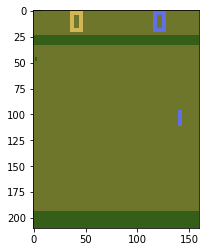

In [2]:
env = gym.make("Pong-v0")
frame = env.reset()

print('原始畫面，shape為：', frame.shape)
plt.imshow(frame)
plt.show()

### * AtariRescale42x42類

In [3]:
# 確保env的observation_space會是一個值介於0至1的Box
class AtariRescale42x42(gym.ObservationWrapper):

    def __init__(self, env=None):
        super(AtariRescale42x42, self).__init__(env)
        self.observation_space = Box(0.0, 1.0, [1, 42, 42])

    def _observation(self, observation):
        return _process_frame42(observation)




def _process_frame42(frame):
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (42, 42))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    return frame

In [4]:
print(env)
env = AtariRescale42x42(env)
print(env)
print(env.observation_space)

<TimeLimit<AtariEnv<Pong-v0>>>
<AtariRescale42x42<TimeLimit<AtariEnv<Pong-v0>>>>
Box(1, 42, 42)


In [5]:
# Method Resolution Order
env.__class__.mro()

[__main__.AtariRescale42x42,
 gym.core.ObservationWrapper,
 gym.core.Wrapper,
 gym.core.Env,
 object]

### * _process_frame42函數

裁切之後的畫面，shape為： (160, 160, 3)


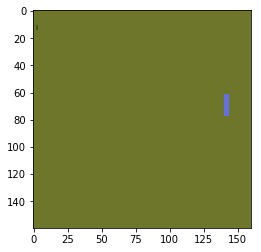

像素的分佈。
[ 24  43  53  95 101 109 111 118 228]
[    8 25528     8     8    64 25528    64 25528    64]


In [6]:
# 裁切
frame = frame[34:34 + 160, :160]

print('裁切之後的畫面，shape為：', frame.shape)
plt.imshow(frame)
plt.show()

print('像素的分佈。')
pixel, count = np.unique(frame, return_counts=True)
print(pixel)
print(count)

mapping至80x80之後的畫面，shape為： (80, 80, 3)


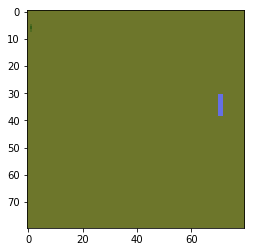

像素的分佈。
[ 24  34  43  53  81  95 101 107 109 111 118 228]
[   1    2 6381    1    2    1   16    2 6381   16 6381   16]


In [7]:
# 藉由cv2套件的幫助，將frame mapping至42x42
frame = cv2.resize(frame, (80, 80))

print('mapping至80x80之後的畫面，shape為：', frame.shape)
plt.imshow(frame)
plt.show()

print('像素的分佈。')
pixel, count = np.unique(frame, return_counts=True)
print(pixel)
print(count)

mapping至42x42之後的畫面，shape為： (42, 42, 3)


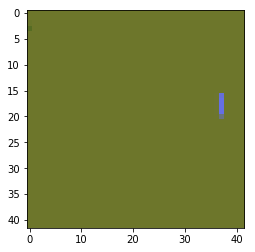

像素的分佈。
[ 35  42  43  45  47  86 101 102 105 108 109 111 115 117 118 127 215 228]
[   1    1 1752    1    4    1    3    1    2    1 1757    4    1    1 1757
    1    1    3]


In [8]:
# 藉由cv2套件的幫助，將frame mapping至42x42
frame = cv2.resize(frame, (42, 42))

print('mapping至42x42之後的畫面，shape為：', frame.shape)
plt.imshow(frame)
plt.show()

print('像素的分佈。')
pixel, count = np.unique(frame, return_counts=True)
print(pixel)
print(count)

三個channel取平均之後，shape為： (42, 42)


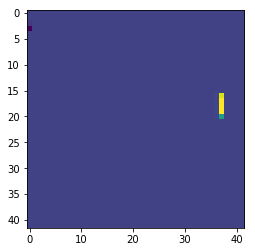

像素的分佈。
[  76.33333333   88.           90.           90.66666667   91.33333333
  115.66666667  142.66666667  146.66666667]
[   1    1 1752    1    4    1    1    3]


In [9]:
# 取三個channel的平均
frame = frame.mean(2)

print('三個channel取平均之後，shape為：', frame.shape)
plt.imshow(frame)
plt.show()

print('像素的分佈。')
pixel, count = np.unique(frame, return_counts=True)
print(pixel)
print(count)

正規化之後，shape為： (42, 42)


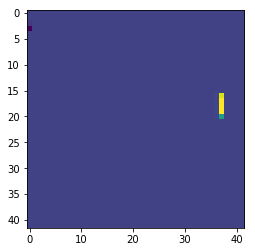

像素的分佈。
[ 0.29934645  0.34509805  0.35294119  0.35555556  0.35816997  0.45359477
  0.55947715  0.57516342]
[   1    1 1752    1    4    1    1    3]


In [10]:
# 正規化
frame = frame.astype(np.float32)
frame *= (1.0 / 255.0)

print('正規化之後，shape為：', frame.shape)
plt.imshow(frame)
plt.show()

print('像素的分佈。')
pixel, count = np.unique(frame, return_counts=True)
print(pixel)
print(count)

### * NormalizedEnv類

In [11]:
print('前處理完frame的mean:', frame.mean())
print('前處理完frame的std: ', frame.std())

前處理完frame的mean: 0.353472
前處理完frame的std:  0.0107404


In [12]:
state_mean = 0
state_std = 0
alpha = 0.9999
num_steps = 0

In [13]:
# 例如Bootstrap的方法逼近mean與std的不偏估計
num_steps += 1
state_mean = state_mean * alpha + frame.mean() * (1 - alpha)
state_std = state_std * alpha + frame.std() * (1 - alpha)

unbiased_mean = state_mean / (1 - pow(alpha, num_steps))
unbiased_std = state_std / (1 - pow(alpha, num_steps))

ret = (frame - unbiased_mean) / (unbiased_std + 1e-8)

In [14]:
# class的整體樣貌
class NormalizedEnv(gym.ObservationWrapper):

    def __init__(self, env=None):
        super(NormalizedEnv, self).__init__(env)
        self.state_mean = 0
        self.state_std = 0
        self.alpha = 0.9999
        self.num_steps = 0

    def _observation(self, observation):
        self.num_steps += 1
        self.state_mean = self.state_mean * self.alpha + \
            observation.mean() * (1 - self.alpha)
        self.state_std = self.state_std * self.alpha + \
            observation.std() * (1 - self.alpha)

        unbiased_mean = self.state_mean / (1 - pow(self.alpha, self.num_steps))
        unbiased_std = self.state_std / (1 - pow(self.alpha, self.num_steps))
        ret = (observation - unbiased_mean) / (unbiased_std + 1e-8)
        return np.expand_dims(ret, axis=0)

# a3c.py

In [15]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [16]:
# 先創造一個環境，待會給Actor網路與Critic網路實驗
def create_atari_env(env_id):
    env = gym.make(env_id)
    env = AtariRescale42x42(env)
    env = NormalizedEnv(env)
    return env

In [17]:
env = create_atari_env('Pong-v0')
env

[2017-06-08 04:24:55,086] Making new env: Pong-v0


<NormalizedEnv<AtariRescale42x42<TimeLimit<AtariEnv<Pong-v0>>>>>

In [18]:
# 取得Pong環境的input & output
num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.n

print('inputs size:', num_inputs)
print('outputs size:', num_outputs)

inputs size: 1
outputs size: 6


In [19]:
# 單看Actor網路
class Actor(torch.nn.Module):
    
    def __init__(self, num_inputs, num_outputs):
        
        super(Actor, self).__init__()
        
        # 捲積層
        # 42x42, 42+2=44, 捲成 21x21
        self.conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
        # 21x21, 21+2=23, 捲成 11x11
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        # 11x11, 11+2=13, 捲成 6x6
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        # 6x6, 6+2=8, 捲成 3x3 
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        
        # LSTM
        self.lstm = nn.LSTMCell(32 * 3 * 3, 256)
        
        # actor-critic
        self.actor_linear = nn.Linear(256, num_outputs)
        
    def forward(self, inputs):
        inputs, (hx, cx) = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        
        x = x.view(-1, 32 * 3 * 3) # 展開乘1x288的向量
        hx, cx = self.lstm(x, (hx, cx))
        x = hx
        
        return self.actor_linear(x)

In [20]:
actor = Actor(num_inputs, num_outputs)
print(actor)

Actor (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTMCell(288, 256)
  (actor_linear): Linear (256 -> 6)
)


In [21]:
state = env.reset()
state = torch.from_numpy(state)
state = Variable(state.unsqueeze(0))

cx = Variable(torch.zeros(1, 256))
hx = Variable(torch.zeros(1, 256))

print(state.size())

torch.Size([1, 1, 42, 42])


In [22]:
output = actor((state, (hx, cx)))
print(output)

Variable containing:
1.00000e-02 *
 -4.3549 -1.1613  7.0166 -2.2596 -0.0304 -2.6552
[torch.FloatTensor of size 1x6]



In [23]:
# 接著單看Critic網路
class Critic(torch.nn.Module):
    
    def __init__(self, num_inputs, num_outputs):
        
        super(Critic, self).__init__()
        
        # 捲積層
        # 42x42, 42+2=44, 捲成 21x21
        self.conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
        # 21x21, 21+2=23, 捲成 11x11
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        # 11x11, 11+2=13, 捲成 6x6
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        # 6x6, 6+2=8, 捲成 3x3 
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        
        # LSTM
        self.lstm = nn.LSTMCell(32 * 3 * 3, 256)
        
        # actor-critic
        self.critic_linear = nn.Linear(256, 1)
        
    def forward(self, inputs):
        inputs, (hx, cx) = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        
        x = x.view(-1, 32 * 3 * 3) # 展開乘1x288的向量
        hx, cx = self.lstm(x, (hx, cx))
        x = hx
        
        return self.critic_linear(x)

In [24]:
critic = Critic(num_inputs, num_outputs)
print(critic)

Critic (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTMCell(288, 256)
  (critic_linear): Linear (256 -> 1)
)


In [25]:
output = critic((state, (hx, cx)))
print(output)

Variable containing:
1.00000e-04 *
  2.3232
[torch.FloatTensor of size 1x1]



In [26]:
# 現在來看看weights_init做了什麼事情
conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
weight_shape = list(conv1.weight.data.size())
print(weight_shape)

[32, 1, 3, 3]


In [27]:
print(weight_shape[1:4]) # 取得權重的size，也就是convolution kernel的size
print(np.prod(weight_shape[1:4]))
# 因為下一個捲積層也是3x3的kernel共32個，因此9x32，也就是說output的weight param共有288個
print(np.prod(weight_shape[2:4]) * weight_shape[0]) 

[1, 3, 3]
9
288


### 有了input跟output的數量就能做Xavier init，目的在於input與output有相同的variance  
### 詳細推導可看這裡 http://ppt.cc/GDWR4

In [28]:
# normalized_columns_initializer就是做norm 2的正規化，並以std來控制拉伸的長度
std = 1.0

out = torch.randn(conv1.weight.size())
print(out[0])
out *= std / torch.sqrt(out.pow(2).sum(1).expand_as(out))
print(out[0])


(0 ,.,.) = 
  1.1217 -1.2631  0.9653
 -2.4926  2.1924  0.1206
 -0.5702 -0.8019  1.1315
[torch.FloatTensor of size 1x3x3]


(0 ,.,.) = 
  1.0000 -1.0000  1.0000
 -1.0000  1.0000  1.0000
 -1.0000 -1.0000  1.0000
[torch.FloatTensor of size 1x3x3]



### 將上述融合在一起就是ActorCritic網路，除了output layer外，其餘layer共享param


### 實作Adam with shared statist

In [31]:
# 實作PyTorch中的Adam類，先拿剛剛的critic套入
adam = optim.Adam(critic.parameters())

In [32]:
adam.param_groups[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay'])

In [33]:
%%time
# 初始化Adam的統計量，如first & second moment estimate與step
for p in adam.param_groups[0]['params']:
    state = adam.state[p]
    state['step'] = torch.zeros(1)
    state['exp_avg'] = p.data.new().resize_as_(p.data).zero_()
    state['exp_avg_sq'] = p.data.new().resize_as_(p.data).zero_()

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 3.11 ms


In [34]:
state

{'exp_avg': 
  0
 [torch.FloatTensor of size 1], 'exp_avg_sq': 
  0
 [torch.FloatTensor of size 1], 'step': 
  0
 [torch.FloatTensor of size 1]}

In [35]:
# 實作Adam
exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
beta1, beta2 = adam.param_groups[0]['betas']

print('exp_avg', exp_avg)
print('exp_avg_sq', exp_avg_sq)
print('beta1', beta1)
print('beta2', beta2)

exp_avg 
 0
[torch.FloatTensor of size 1]

exp_avg_sq 
 0
[torch.FloatTensor of size 1]

beta1 0.9
beta2 0.999


In [36]:
# 根據Adam論文(https://arxiv.org/pdf/1412.6980.pdf)實作
# 先假設有gradient且等於1
grad = torch.ones(1)
print(grad)

# 以下這句等同於 exp_avg = beta1 * exp_avg + (1 - beta1) * grad
exp_avg.mul_(beta1).add_((1 - beta1) * grad)
print(exp_avg)

# 以下這句等同於 exp_avg_sq = beta2 * exp_avg_sq + (1 - beta2) * grad^2
exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
print(exp_avg_sq)


 1
[torch.FloatTensor of size 1]


 0.1000
[torch.FloatTensor of size 1]


1.00000e-03 *
  1.0000
[torch.FloatTensor of size 1]



In [37]:
# 以下都是實作Adam論文，詳情請看論文第2頁

denom = exp_avg_sq.sqrt().add_(adam.param_groups[0]['eps'])
bias_correction1 = 1 - beta1 ** state['step'][0]
bias_correction2 = 1 - beta2 ** state['step'][0]
step_size = adam.param_groups[0]['lr'] * np.sqrt(bias_correction2) / bias_correction1

print('denom', denom)
print('bias_correction1', bias_correction1)
print('bias_correction2', bias_correction2)
print('step_size', step_size)

denom 
1.00000e-02 *
  3.1623
[torch.FloatTensor of size 1]

bias_correction1 0.0
bias_correction2 0.0
step_size nan


/home/nailo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


# actor.py

In [38]:
# actor.py實作了每個thread的actor-learner
# 拿actor網路來做實驗

env = create_atari_env('Pong-v0')
state = env.reset()
state = torch.from_numpy(state)
state = Variable(state.unsqueeze(0))

cx = Variable(torch.zeros(1, 256))
hx = Variable(torch.zeros(1, 256))

output = actor((state, (hx, cx)))
print(output)

[2017-06-08 04:25:04,825] Making new env: Pong-v0


Variable containing:
1.00000e-02 *
 -4.3549 -1.1613  7.0166 -2.2596 -0.0304 -2.6552
[torch.FloatTensor of size 1x6]



In [39]:
# 由於為了計算entropy，因此建神經網路時最後一層不套activation function
# 得出output後再各別計算probability與log probability

prob = F.softmax(output)
log_prob = F.log_softmax(output)
entropy = -(log_prob * prob).sum(1)

print('prob:', prob.data.numpy()[0])
print('log_prob:', log_prob.data.numpy()[0])
print('entropy:', entropy.data.numpy()[0][0])

prob: [ 0.16037484  0.16557916  0.17968914  0.1637705   0.16746235  0.16312402]
log_prob: [-1.83024144 -1.79830587 -1.71652699 -1.80928922 -1.78699672 -1.81324446]
entropy: 1.79107


In [40]:
# 從multinomial分佈中抽樣，例如抽一千次，分佈長以下這樣
actions = []
for _ in range(1000):
    actions.append(prob.multinomial().data.numpy()[0][0])
    
print(np.unique(actions, return_counts=True))

(array([0, 1, 2, 3, 4, 5]), array([157, 158, 194, 173, 161, 157]))
